### 1 - K-Means

K-means is a **center-based** clustering method; it is still widely used, owing its popularity to the relative simplicity of the algorithm and its ability to scale to large data sets. K-means divides the data into K clusters by minimizing the sum of the squared distances of each record to the mean of its assigned cluster. This is referred to as the within-cluster sum of squares or within-cluster SS. K-means does not ensure the clusters will have the same size but finds the clusters that are the best separated.<br>
It is typical to normalize (standardize) continuous variables by subtracting the mean and dividing by the standard deviation. Otherwise, variables with large scale will dominate the clustering process.<br>
Usecase: even cluster size, flat geometry, not too many clusters, ***inductive***.<br>
It's recommended to apply **PCA** on data prior to K-means.

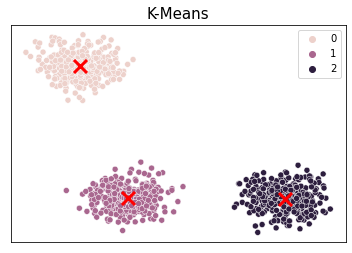

In [43]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

X, y = make_blobs(n_samples=1000, random_state=41)

# Create K-means clustering object with a specified number of clusters
kmeans = KMeans(n_clusters=3, random_state=42)

labels = kmeans.fit_predict(X)
centroids = kmeans.cluster_centers_

sns.scatterplot(data=X, x=X[:,0], y=X[:,1], hue=labels)
plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, linewidths=3,
            color="r", zorder=10)
plt.title('K-Means',fontsize=15)
plt.xticks(())
plt.yticks(())
plt.show()

The K-means algorithm requires that you specify the number of clusters K; a statistical approach could be used, however, there is no single standard method to find the “best” number of clusters. A common approach, called the **elbow method**, is to identify when the set of clusters explains “most” of the variance in the data. Adding new clusters beyond this set contributes relatively little in the variance explained. The elbow is the point where the cumulative variance explained flattens out after rising steeply, hence the name of the method.

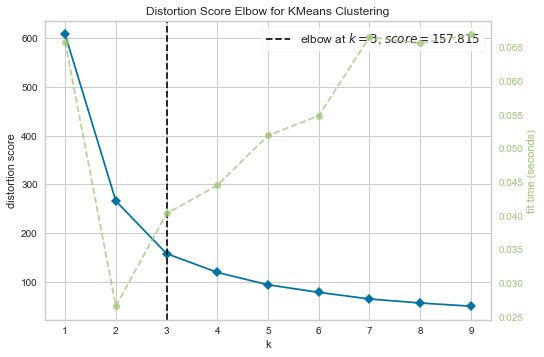

Best K is 3


In [38]:
from yellowbrick.cluster import KElbowVisualizer

kmeans  = KMeans()
kmeans_labels = kmeans.fit_predict(X)
visualizer = KElbowVisualizer(kmeans, k=(1,10))
visualizer.fit(X)   
visualizer.show()

print('Best K is', visualizer.elbow_value_)

The alternative K-means algorithm for Big Data is **Mini-Batch K-Means** clustering with the following syntax:

In [ ]:
kmeans = MiniBatchKMeans(n_clusters=2, random_state=0, batch_size=6)
kmeans = kmeans.partial_fit(X[0:6,:])
kmeans = kmeans.partial_fit(X[6:12,:])

### 2 - Gaussian mixture models (GMM)

A GMM is a **probabily-based** model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. One can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians.<br>
Usecase: Flat geometry, good for density estimation, ***inductive***.

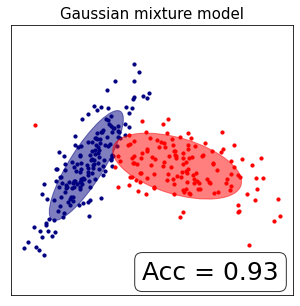

In [39]:
import numpy as np
import matplotlib as mpl
from sklearn.datasets import make_classification
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt 
from sklearn import metrics


X, y = make_classification(n_samples=300, n_features=2, n_informative=2, 
                           n_redundant=0, n_clusters_per_class=1, random_state=4)

# define the model
model = GaussianMixture(n_components=2)

# fit the model
model.fit(X)
labels = model.predict(X)


plt.figure(figsize=(4, 4))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)

h = plt.subplot(1, 1, 1)
colors = ['navy','red']


def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        covariances = gmm.covariances_[n][:2, :2]
        
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')
        
make_ellipses(model, h)

for n, color in enumerate(colors):
        data = X[labels == n]
        plt.scatter(data[:, 0], data[:, 1], s=10, color=color)
        

score=metrics.accuracy_score(y, labels)       
h.text(0.95, 0.06, ('Acc = %.2f' % score).lstrip('0'), size=25,
                bbox=dict(boxstyle='round', alpha=0.8, facecolor='white'),
                transform=h.transAxes, horizontalalignment='right')

plt.xticks(())
plt.yticks(())
plt.title('Gaussian mixture model',fontsize=15)
plt.show()

The **Bayesian Information Criteria (BIC) criterion** can be used to select the number of components in a Gaussian Mixture in an efficient way. BIC works by selecting the best-fitting model with a penalty for the number of parameters in the model. In the case of model-based clustering, adding more clusters will always improve the fit at the expense of introducing additional parameters in the model.

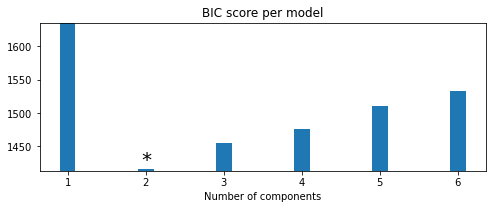

In [28]:
lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)

for n_components in n_components_range:
    
    # Fit a Gaussian mixture with EM
    gmm = GaussianMixture(n_components=n_components,
                                  covariance_type='full')
    gmm.fit(X)
    bic.append(gmm.bic(X))
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        best_gmm = gmm
        
bic = np.array(bic)
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
ax = plt.subplot(2, 1, 1)

xpos = np.array(n_components_range)
bars.append(plt.bar(xpos, bic, width=.2))

plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')

plt.text(bic.argmin()+0.95, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=20)
ax.set_xlabel('Number of components')
plt.show()

### 3 - DBSCAN

**DBSCAN** or "Density-Based Spatial Clustering of Applications with Noise", is a **density-based** model that finds core samples of high density and expands clusters from them. Good for data which contains clusters of similar density.
<br> There are two parameters to the algorithm, min_samples and eps, which define formally what we mean when we say dense. Higher min_samples or lower eps indicate higher density necessary to form a cluster.
<br>**eps:** The maximum distance between two samples for one to be considered as in the neighborhood of the other.
<br>**min_samples:** The number of samples (or total weight) in a neighborhood for a point to be considered as a core point.
<br>Usecase: Non-flat geometry, uneven cluster sizes, ***transductive***.

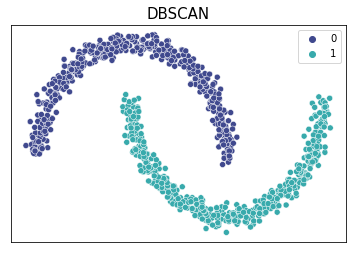

In [49]:
from sklearn import datasets
from sklearn.cluster import DBSCAN
import seaborn as sns

X, y = datasets.make_moons(n_samples=1000, noise=.05)

dbscan = DBSCAN(eps=0.3, min_samples=20)
dbscan.fit(X)
labels = dbscan.labels_.astype(int)

sns.scatterplot(data=X, x=X[:,0], y=X[:,1], hue=labels, palette='mako')
plt.title('DBSCAN',fontsize=15)
plt.xticks(())
plt.yticks(())
plt.show()

### 4 - Agglomerative

The AgglomerativeClustering algorithm is a **graph-based** model that performs a hierarchical clustering using a bottom up approach: each observation starts in its own cluster, and clusters are successively merged together. 
<br>
Usecase: Many clusters, possibly connectivity constraints, non Euclidean distances, ***transductive***.

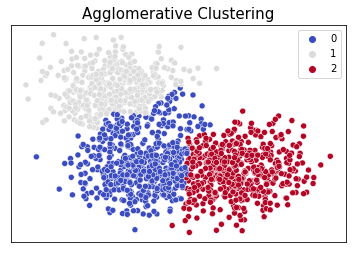

In [51]:
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
import matplotlib.pyplot as plt 

X, y = make_blobs(n_samples=1500, cluster_std=3 , random_state=41)

ward = AgglomerativeClustering(n_clusters=3, linkage='ward')

ward.fit(X)
labels = ward.labels_.astype(int)

sns.scatterplot(data=X, x=X[:,0], y=X[:,1], hue=labels, palette='coolwarm')
plt.title('Agglomerative Clustering',fontsize=15)
plt.xticks(())
plt.yticks(())
plt.show()